In [1]:
import numpy as np
import itertools
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
items = []
def addGroup(name,obj):
    if isinstance(obj,h5py.Group):
        items.append(addGroup)
with h5py.File('test.h5','r') as f:
    f.visititems(func)
    
print([''.join(x.split('/')) for x in items])
#print([''.join(x.split('/')[1:])  for x in items if 'Data' not in x])

['0', '00', '01', '02', '03']


In [104]:

class Data():
    def __init__(self,data=None):
        self.copy(data)
    
    def copy(self,data):
        if data is None:
            self.data = np.zeros((4,))
        else:
            self.data = data.data.copy()
class Node():
    def __init__(self,indx,parent=None,data=None):
        self.indx = indx
        self.level = len(indx)-1
        self.global_index = (0,0,0)
        self.parent = parent
        if parent is not None:
            self.global_index = self.calc_global_index(*parent.global_index)
        self.leaf = True
        self.child = [None]*4
        
        self.data = Data(data)
    def calc_global_index(self,k,i,j):
        """
        Calculate the global index for the cell given (k,i,j).
        (k,i,j) can either be from the level above or the level below
        """
        if k==self.level:
            # Same level
            return (k,i,j)
        elif k < self.level:
            # Going from coarser level
            inew = 2*i + i//2
            jnew = 2*j + j%2
            return (k+1,inew,jnew)
        else:
            # Going from finer level
            inew = i // 2
            jnew = j // 2
            return (k-1,inew,jnew)
    def name_from_index(self,k,i,j):
        """
        Calculate the name of the cell corresponding to 
        global index (k,i,j)
        """
        name = []
        icurr = i
        jcurr = j
        for curr_level in range(k+1)[::-1]:
            name.append(str(2*(icurr%2)+jcurr%2))
            icurr = icurr // 2
            jcurr = jcurr // 2
        return ''.join(name[::-1])
    def index_from_name(self,name):
        """
        Calculate the index of the cell corresponding to 
        the given name
        """
        icurr = 0
        jcurr = 0
        for k,c in enumerate(name):
            icurr = 2*icurr + int(c)//2
            jcurr = 2*jcurr + int(c)%2
        
        return (len(name)-1,icurr,jcurr)
            
            
    def split(self):
        self.leaf = False
        for i in range(4):
            name = self.indx + str(i)
            self.child[i] = Node(name,self)
        return self.child
    def find_neighbors(self):
        """Start with neighbors on same level"""
        myindx = self.global_index
        n_name = []
        n_name_upper = []
        for i in range([-1,0,1]):
            for j in range([-1,0,1]):
                if ~((i==0)&(j==0)):
                    nindx = (myindx[0], myindx[1]+i,myindx[2]+j)
                    nindx_upper = (nindx[0]-1,nindx[1]//2,nindx[2]//2)
                    n_name.append( self.name_from_index(nindx))
                    n_name_upper.append(self.name_from_index( nindx_upper))
        return n_name, n_name_upper
    def eval_neighbors(self,neighbors,neighbors_upper,cuttof=10.):
        res = False
        for n,nu in zip(neighbors,neighbors_upper):
            node = self.find(nu)
            if node.leaf:
                res |= (node.compare(self) or node.r_flag)
            else:
                res |= (node.child[int(n[-1])].compare(self) or node.r_flag)
        return res
    def check_refinement(self,cuttoff=10.):
        neighbors, neighbors_upper = self.find_neighbors()
        self.refine = self.eval_neighbors(neighbors,neighbors_upper,cuttoff=cuttoff)
        return self.refine
    def compare(self,node,cuttoff=10.):
        return abs(self.data.data[0] - node.data.data[0]) < cuttoff 
    def find(self,name):
    """
       Find the next step towards the desired 
       node with name name.
    """ 
        len_myself = len(self.indx)
        len_name = len(name)
        if self.indx == name:
            # Found it!
            return self
        if len_myself < len_name:
            if self.indx == name[:len_myself]:
                # It's below us in the tree
                child = name[:len_myself+1][-1]
                return self.down(int(child)).find(name)
        # It's not below us, so move up
        return self.up().find(name)
        
    def up(self):
        return self.parent
    def down(self,i=0):
        return self.child[i] 
    def walk(self):
        if self.leaf:
            return self
        for c in self.child:
            return c.walk()
    def save(self,f):
        f.create_dataset('Data',data=self.data)
        if not self.leaf:
            for i,c in enumerate(self.child):
                grp = f.create_group(str(i))
                c.save(grp)
        
    def __repr__(self):
        return self.indx
    def __str__(self):
        return self.indx

In [100]:
root = [Node('0')]
root.append(root[0].split())
for i in range(7):
    root.append(list(itertools.chain.from_iterable([x.split() for x in root[-1]])))
    


In [154]:
for j in range(1,4):
    for i in range(4):
        print('{:d}: {:d} -> {:d}'.format(j,i,i^j))

1: 0 -> 1
1: 1 -> 0
1: 2 -> 3
1: 3 -> 2
2: 0 -> 2
2: 1 -> 3
2: 2 -> 0
2: 3 -> 1
3: 0 -> 3
3: 1 -> 2
3: 2 -> 1
3: 3 -> 0


In [164]:
for i in range(4):
    print('{:d} -> {:d}'.format(i,i//2))

0 -> 0
1 -> 0
2 -> 1
3 -> 1


In [170]:
for indx in [ (2**4,2**4),(2**4,2**4+1),(2**4+1,2**4),(2**4+1,2**4+1)]:
    print('({:d},{:d},{:d}) -> ({:d},{:d},{:d})'.format(4,indx[0],indx[1],3,indx[0]//2 + indx[0]%2,indx[1]//2 + indx[1]%2))

(4,16,16) -> (3,8,8)
(4,16,17) -> (3,8,9)
(4,17,16) -> (3,9,8)
(4,17,17) -> (3,9,9)


In [181]:
for indx in [ (2**4,2**4),(2**4,2**4+1),(2**4+1,2**4),(2**4+1,2**4+1)]:
    print(indx,[x%2 for x in indx],2*(indx[0]%2)+indx[1]%2)

(16, 16) [0, 0] 0
(16, 17) [0, 1] 1
(17, 16) [1, 0] 2
(17, 17) [1, 1] 3


In [186]:
k,i,j = (5,14,7)
name = []
icurr = i
jcurr = j
for curr_level in range(k+1)[::-1]:
    print((curr_level,icurr,jcurr))
    name.append(str(2*(icurr%2)+jcurr%2))
    icurr = icurr // 2
    jcurr = jcurr // 2
print(''.join(name[::-1]))

(5, 14, 7)
(4, 7, 3)
(3, 3, 1)
(2, 1, 0)
(1, 0, 0)
(0, 0, 0)
002331


In [195]:
icurr = 0
jcurr = 0
print(len('002331'))
for k,c in enumerate('002331'):
    icurr = 2*icurr + int(c)//2
    jcurr = 2*jcurr + int(c)%2
    print((k,icurr,jcurr))

6
(0, 0, 0)
(1, 0, 0)
(2, 1, 0)
(3, 3, 1)
(4, 7, 3)
(5, 14, 7)


In [40]:
list(itertools.chain.from_iterable(l2))

[000,
 001,
 002,
 003,
 010,
 011,
 012,
 013,
 020,
 021,
 022,
 023,
 030,
 031,
 032,
 033]

In [196]:
n1 = '002331'
n0 = '00201'

In [219]:
n1.split('0023')

['', '31']

In [220]:
[(n0[:i],(n0[:i] in n1)) for i in range(1,len(n0)+1)]

[('0', True), ('00', True), ('002', True), ('0020', False), ('00201', False)]

In [217]:
n0[:-1],n0[-1]

('0020', '1')

In [2]:
for c in '0023':
    print(c)

0
0
2
3


In [28]:
file = h5py.File('test.h5','r')

In [145]:
def make_node(f,level):
    if level > 10:
        f.create_dataset('Data',data=np.random.rand(4,))
        return
    if np.random.rand() < .3:
        f.create_dataset('Data',data=np.random.rand(4,))
    else:
        for i in range(4):
            grp = f.create_group(str(i))
            make_node(grp,level+1)
    return
    
with h5py.File('test5.h5','w') as f:
    root = f.create_group('0')
    level = 0
    for i in range(4):
        grp = root.create_group(str(i))
        make_node(grp,level+1)
        
       

            

In [361]:
def open_group(grp,indx,func_node,func_leaf):
    for i in range(4):
        try:
            newgrp = grp[str(i)]
            func_node(indx+str(i))
            open_group(newgrp,indx+str(i),func_node,func_leaf)
        except KeyError:
            func_leaf(indx)
            return 
def walk_h5(file):
    nodes = []; leaves = [];
    func1 = lambda x: nodes.append(x)
    func2 = lambda x: leaves.append(x)
    with h5py.File(file,'r') as f:
        grp = f['0']
        nodes.append('0')
        for i in range(4):
            nodes.append('0'+str(i))
            open_group(grp[str(i)],'0'+str(i),func1,func2)
    return nodes,leaves

In [375]:
nodes,leaves=walk_h5('test2.h5')

In [376]:
leaves[6]

'0012'

In [386]:
with h5py.File('test2.h5','r') as f:
    grp = f['/'.join(leaves[1])]['Data']
    print(grp)
    dat=Data(file=grp)


<HDF5 group "/0/0/0/1/Data" (3 members)>
<HDF5 group "/0/0/0/1/Data" (3 members)>
<HDF5 group "/0/0/0/1/Data" (3 members)>
<HDF5 group "/0/0/0/1/Data" (3 members)>


In [396]:
t2.close()
t2 = Tree(fname='test2.h5')

In [397]:
t2.build()

<HDF5 group "/0/0/0/0/Data" (3 members)>
<HDF5 group "/0/0/0/0/Data" (3 members)>
<HDF5 group "/0/0/0/0/Data" (3 members)>
<HDF5 group "/0/0/0/1/Data" (3 members)>
<HDF5 group "/0/0/0/1/Data" (3 members)>
<HDF5 group "/0/0/0/1/Data" (3 members)>
<HDF5 group "/0/0/0/2/Data" (3 members)>
<HDF5 group "/0/0/0/2/Data" (3 members)>
<HDF5 group "/0/0/0/2/Data" (3 members)>
<HDF5 group "/0/0/0/3/Data" (3 members)>
<HDF5 group "/0/0/0/3/Data" (3 members)>
<HDF5 group "/0/0/0/3/Data" (3 members)>
<HDF5 group "/0/0/1/0/Data" (3 members)>
<HDF5 group "/0/0/1/0/Data" (3 members)>
<HDF5 group "/0/0/1/0/Data" (3 members)>
<HDF5 group "/0/0/1/1/Data" (3 members)>
<HDF5 group "/0/0/1/1/Data" (3 members)>
<HDF5 group "/0/0/1/1/Data" (3 members)>
<HDF5 group "/0/0/1/2/Data" (3 members)>
<HDF5 group "/0/0/1/2/Data" (3 members)>
<HDF5 group "/0/0/1/2/Data" (3 members)>
<HDF5 group "/0/0/1/3/Data" (3 members)>
<HDF5 group "/0/0/1/3/Data" (3 members)>
<HDF5 group "/0/0/1/3/Data" (3 members)>
<HDF5 group "/0/

In [249]:
res=[[(0,0),(0,1),(0,2)],[(1,0),(1,1),(1,2)],[(2,0),(2,1),(2,2)]]
for r in [i for x in res for i in x]:
    print(r)

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


In [367]:
class Tree():
    """
        The tree holds high level functions for interacting with
        the nodes.
    """
    def __init__(self,fname=None):
        """
            Initialize a tree from the hdf5 file fname
        """
        self.file = fname
        if fname is None:
            return
        
        try:
            self.open(fname)
            
        except OSError:
            print('File not found')
            self.file = None
    
    def build(self,data=None):
        """
            Build the tree from the hdf5 file
        """
        if self.file is None:
            self.root = Node('0',data=data)
            return
        self.root = Node('0')
        grp = self.file['0']
        self.root.build(grp)
            
    def open(self,fname):
        self.file = h5py.File(fname,'r')
    def close(self):
        self.file.close()
    def depth(self):
        lvls = []
        self.walk(func=lambda x: lvls.append(len(x.indx)-1))
        return max(lvls)
    def compression(self):
        leaves = self.list_leaves()
        maxlvl = max([len(n)-1 for n in leaves])
        npoints = 2**maxlvl * 2**maxlvl
        return 1-len(leaves)/float(npoints)
    def empty_leaves(self):
        """
            Build a list of leaves with no data.
        """
        nodes =[]
        self.walk(func=lambda x: nodes.append(x.indx) if x.leaf and x.data is None else None)
        return nodes
    def list_leaves(self):
        """
            Build a list of all leaves.
        """
        nodes = []
        self.walk(func=lambda x: nodes.append(x.indx))
        return nodes
        
    def walk(self,**kargs):
        """
            Walk the tree starting from the root.
        """
        return self.root.walk(**kargs)
    def refine(self,corners=False,**kargs):
        leaves = self.list_leaves()
        # Reorder based on level
        lvls = np.array([len(x) for x in leaves])
        inds = np.argsort(lvls)[::-1]
        leaves = list(np.array(leaves)[inds])
        for leaf in leaves:
            t.find(leaf).refine(corners=corners,**kargs)
        for leaf in leaves:
            node = t.find(leaf)
            if node.rflag:
                _,nuppers = node.find_neighbors(corners=corners)
                for upper in [i for x in nuppers for i in x]:
                    if upper is not None:
                        n = node.find(upper)
                        if n.leaf:
                            n.rflag = True
        
    def start_refine(self):
        for leaf in self.list_leaves():
            node = t.find(leaf)
            if node.rflag:
                node.split()
                node.rflag = False
        # Return a list of new, empty leaves
        return self.empty_leaves()
                
    def find(self,name):
        """
            Find node starting from the root
        """
        current_node = self.root
        for c in name[1:]:
            current_node = current_node.child[int(c)]
        return current_node
    def plot(self,fig=None,ax=None,vmin=0,vmax=180,cmap='viridis',**kargs):
        import matplotlib.colorbar as cbar
        import matplotlib.colors as colors
        if ax is None:
            fig,ax = plt.subplots()
        norm = colors.Normalize(vmin=vmin,vmax=vmax)
        self.root.plot(ax,norm=norm,cmap=cmap,**kargs)
#         cax, _ = cbar.make_axes(ax) 
#         cb2 = cbar.ColorbarBase(cax,cmap=cmap,norm=norm)
    def save(self,fname):
        """
            Save the whole tree to an hdf5 file.
        """
        with h5py.File(fname,'w') as f:
            self.root.save(f)
            
class Data():
    cols=['x','y','z']
    def __init__(self,node=None,file=None,data=None):
        if node is None:
            self.xc = 0.
            self.yc = 0.
        else:
            self.xc,self.yc = node.get_xy()
            
        if data is not None:
            for c in self.cols:
                setattr(self,c,getattr(data,c))
        elif file is None:
            for c in self.cols:
                setattr(self,c,self.func())
        else:
            for c in self.cols:
                setattr(self,c,file[c][...])
    def func(self):
        x = (self.xc-.5)*10
        y = (self.yc-.5)*10
        r2 = x**2 + y**2
        return (1 - (5./3-1) * 5**2 /(8*5./3*np.pi**2) * np.exp(1.-r2))**(1./(5./3-1))
    def copy(self):
        return Data(data=self)
    def save(self,file):
        grp = file.create_group('Data')
        for c in self.cols:
            grp.create_dataset(c,data=getattr(self,c))
            
    def refinement_lohner(self,nodes,eps=.01,tol=.8,symmetric=True,**kargs):
        ans = [[False,False,False],[False,False,False],[False,False,False]]
       
        u = self.x
        
        resx = 0.
        try:
            uR = nodes[2][1].data.x
        except:
            uR = u
        try:
            uL = nodes[0][1].data.x
        except:
            uL = u
            
        resx = abs(uR-2*u+uL)
        if abs(resx) < 1e-8:
            resx = 0
        else:
            resx /= ( abs(uR-u) + abs(u-uL) + eps*(abs(uR)+2*u+abs(uL)))
        
        resy = 0
        try:
            uR = nodes[1][2].data.x
        except:
            uR = u
        try:
            uL = nodes[1][0].data.x
        except:
            uL = u
        resy = abs(uR-2*u+uL)
        if abs(resy) < 1e-8:
            resy = 0
        else:
            resy /=( abs(uR-u) + abs(u-uL) + eps*(abs(uR)+2*u+abs(uL)))
        
        
        if symmetric:
            res = max(resx,resy)
            resx = res
            resy = res
        
        if resx >= tol:
            ans[1][1] = True
            ans[0][1] = True
            ans[2][1] = True
        if resy >= tol:
            ans[1][1]= True
            ans[1][2] = True
            ans[1][0] = True
        
        return ans
    def refinement_simple(self,nodes,cuttoff=100,**kargs):
        ans = [[False,False,False],[False,False,False],[False,False,False]]
        
        
        u = nodes[1][1].data.x
        
        try:
            ut = nodes[0][1].data.x
            if abs(u-ut) >= cuttoff:
                ans[1][1] |= True
                ans[0][1] |= True
        except:
            pass
        try:
            ut = nodes[2,1].data.x
            if abs(u-ut) >= cuttoff:
                ans[1][1] |= True
                ans[2][1] |= True
        except:
            pass
        try:
            ut = nodes[1,0].data.x
            if abs(u-ut) >= cuttoff:
                ans[1][1] |= True
                ans[1][0] |= True
        except:
            pass
        try:
            ut = nodes[1,2].data.x
            if abs(u-ut) >= cuttoff:
                ans[1][1] |= True
                ans[1][2] |= True
        except:
            pass
        return ans
        
        
    def check_refinement(self,nodes,func='simple',**kargs):
        """Given the neighbors, check for refinement."""
        
        if func == 'simple':
            return self.refinement_simple(nodes,**kargs)
        if func == 'lohner':
            return self.refinement_lohner(nodes,**kargs)
        else:
            return self.refinement_simple(nodes,**kargs)

    
class Node():
    """
        Nodes either point to their children or they have no
        children and instead hold some data.
    """
    def __init__(self,indx,file=None,parent=None,data=None):
        self.indx = indx
        self.name = '/'.join(self.indx)
        self.level = len(indx)-1
        self.global_index = (0,0,0)
        self.parent = parent
        if parent is not None:
            self.global_index = self.index_from_name(self.indx)
        self.leaf = True
        self.rflag = False
        self.child = [None]*4
        self.file = file
        self.data = data
    def save(self,file):
        """
            Write this node to the hdf5 group/file.
        """
        grp = file.create_group(self.indx[-1])
        if self.leaf:
            # We are a leaf, so we should dump our data
            self.data.save(grp)
        else:
            # We are not a group, so call the children
            for c in self.child:
                c.save(grp)
        return

    def build(self,f):
        """
            Look in the hdf5 group f for child cells
        """
        
        
        for i in range(4):
            try:
                grp = f[str(i)]
                self.leaf = False
                self.child[i] = Node(self.indx+str(i),parent=self,file=grp)
                self.child[i].build(grp)
            except KeyError:
                self.leaf = True
                self.datastr = self.name + '/' + str(i) + '/Data'
                self.data=Data(file=f['Data'],node=self)
                return 
        
        return
    def split(self):
        """
            Split the node into four children, and pass the data to the 
            first born.
        """
        self.leaf=False
        self.child[0] = Node(self.indx+'0',parent=self,data=self.data.copy())
        for i in range(1,4):
            self.child[i] = Node(self.indx+str(i),parent=self)
        return
    def name_from_index(self,k,i,j):
        """
            Calculate the name of the cell corresponding to 
            global index (k,i,j)
        """
        name = []
        icurr = i
        jcurr = j
        for curr_level in range(k+1)[::-1]:
            name.append(str(2*(icurr%2)+jcurr%2))
            icurr = icurr // 2
            jcurr = jcurr // 2
        return ''.join(name[::-1])
    def index_from_name(self,name):
        """
            Calculate the index of the cell corresponding to 
            the given name
        """
        icurr = 0
        jcurr = 0
        for k,c in enumerate(name):
            icurr = 2*icurr + int(c)//2
            jcurr = 2*jcurr + int(c)%2
        
        return (len(name)-1,icurr,jcurr)
    def get_xy(self):
        """
            Get the x,y coordinates on the unit square for this
            node.
        """
        k,i,j = self.global_index
        dx = 1./2**k
        return dx*i,dx*j
    def set_data(self,data):
        self.data = data.copy()
    def get_data(self):
        """
            Retrieve the data from the hdf5 file.
        """
        try:
            return self.file['Data'][...]
        except:
            return self.data.x
    def plot(self,ax,**kargs):
        """
            The recursive plotting function.
            Only draw if this is a leaf.
        """
        if self.leaf:
            self.draw(ax,**kargs)
            return
        for c in self.child:
            c.plot(ax,**kargs)
    def draw(self,ax,cmap='Spectral',plot_refined=True,edges=False,**kargs):
        """
            Draw a rectangle for this cell and color by the given 
            data field. 
            If needed, indicate the cell is tagged for refinement.
        """
        import matplotlib.cm
        import matplotlib.patches as patches
        import matplotlib.collections as collections
        
        norm = kargs.pop('norm',None)
        try:
            dat = self.get_data()
            cmap = matplotlib.cm.get_cmap(cmap)
            if norm is not None:
                c = cmap(norm(dat))
            else:
                c = cmap(dat)
        except: 
            dat = np.nan
            c = 'w'
        
            
        k,i,j=self.global_index
        dx = 1./2**k
        dy = dx
        x = dx *i
        y = dy*j
        rect = patches.Rectangle((x,y),dx,dy)
        if edges:
            ax.add_collection(collections.PatchCollection([rect],facecolor=c,edgecolor='k'))#,lw=1))
        else:
            ax.add_collection(collections.PatchCollection([rect],facecolor=c))#,lw=1))
        if plot_refined and self.rflag:
            ax.plot(x+dx/2,y+dy/2,'ro',ms=2)
    
    def find(self,name):
        """
           Find the next step towards the desired 
           node with name name.
        """ 
        len_myself = len(self.indx)
        len_name = len(name)
        if self.indx == name:
            # Found it!
            #print('Node ', self.indx, ' found ',name)
            return self
        if len_myself < len_name:
            if self.indx == name[:len_myself]:
                # It's below us in the tree
                child = name[:len_myself+1][-1]
                #print('Node ', self.indx, ' is going to child ',child)
                return self.down(int(child)).find(name)
        # It's not below us, so move up
        #print('Node ', self.indx, ' is going up to find ',name)

        return self.up().find(name)
    def refine(self,refine_all=False,corners=False,**kargs):
        """
            Check neighbors to see if this node should
            be refined.
        """
        
        # First check if already tagged
            
        neighbors, upper_neighbors = self.find_neighbors(corners=corners)
#        print('Node ', self.indx, ' is finding',neighbors,upper_neighbors)
#         if self.rflag:
#             # Enforce the 2:1 balance.
#             print('2:1 balance')
#             for nu in upper_neighbors:
#                 neighbor = self.find(nu)
#                 if neighbor.leaf:
#                     neighbor.rflag = True
        
        # Even if already tagged, still need to check new neighbors
        final_list = [[None,None,None],[None,None,None],[None,None,None]]
        for i in range(3):
            for j in range(3):
                if upper_neighbors[i][j] is not None:
                    node = self.find(upper_neighbors[i][j])
                    if not node.leaf:
                        node = node.find(neighbors[i][j])
                    final_list[i][j] = node
                
#         for n,nu in zip(neighbors,upper_neighbors):
#             # First go the parent and check if it's a leaf.
#             neighbor = self.find(nu) 
#             if neighbor.indx != nu:
#                 print('BAD')
#             # Go to the child if needed
#             if not neighbor.leaf:
#                 neighbor = neighbor.find(n)
#                 if neighbor.indx != n:
#                     print('BAD')
#             final_list.append(neighbor) # Store direct links to neighbors for later
            
        res = self.data.check_refinement(final_list,**kargs)
        
        for i in range(3):
            for j in range(3):
                if final_list[i][j] is not None:
                    final_list[i][j].rflag |= res[i][j]
#         print(self,neighbor,res)
#         print(self.rflag)
        # Checked all neighbors. Broadcast result if True
        if refine_all:
            if self.rflag:
                for i in range(3):
                    for j in range(3):
                        final_list[i][j].rflag |= True
#                 for n,nu in zip(neighbors,upper_neighbors):
#                     neighbor=self.find(nu)
#                     if not neighbor.leaf:
#                         neighbor = self.find(n)
#                     neighbor.rflag = True
                    
                
        return 
                
        
    def find_neighbors(self,corners=False):
        """
            Find the neighbors and their parents.
        """
        k,i,j = self.global_index
        max_indx = 2**k
        max_indx_up = 2**(k-1)
        neighbors = []
        upper_neighbors = []
        
        
        neighbors = [ [None,None,None],[None,self.indx,None],[None,None,None]]
        upper_neighbors = [ [None,None,None],[None,None if self.parent is None else self.parent.indx,None],[None,None,None]]
        stencil = [(-1,0),(1,0),(0,-1),(0,1)]
        if corners:
            stencil += [(-1,1),(1,-1),(1,1),(-1,-1)]
        
        for di,dj in stencil:
            ii = i + di
            jj = j + dj
            if ii>=0 and jj>=0 and ii<max_indx and jj<max_indx:
           
                neighbors[1+di][1+dj] = self.name_from_index(k,ii,jj)
                #neighbors.append( self.name_from_index(k,ii,jj))
            iu = ii//2
            ju = jj//2
            ku = k-1
            if iu>=0 and ju>=0 and iu<max_indx_up and ju<max_indx_up:
                upper_neighbors[1+di][1+dj] = self.name_from_index(ku,iu,ju)
                #upper_neighbors.append(self.name_from_index(ku,iu,ju))
        return neighbors, upper_neighbors
    def up(self):
        """
            Move up the tree
        """
        return self.parent
    def down(self,i=0):
        """
            Move down the tree to child i
        """
        return self.child[i] 
    def walk(self,printname=False,func=None):
        """
            Recursively walk the tree, applying the function func if this
            is a leaf.
        """
        if self.leaf:
            if func is not None:
                func(self)
            if printname:
                print(self)
            return self
        for c in self.child:
            c.walk(printname=printname,func=func)
    def __repr__(self):
        return self.indx
    def __str__(self):
        return self.indx
                

In [659]:
print(neighbors)
print(upper)
print([index_from_name(n) for n in neighbors])
print([index_from_name(n) for n in upper])


['0330', '0331', '0332']
['033', '033', '033']
[(3, 6, 6), (3, 6, 7), (3, 7, 6)]
[(2, 3, 3), (2, 3, 3), (2, 3, 3)]


In [925]:
t=Tree(fname='test4.h5')

In [926]:
t.build()

In [445]:
t = Tree()
t.build(data=Data())
t.root.split()
for c in t.empty_leaves():
    node = t.find(c)
    node.set_data(Data(node=node))


In [469]:
nodes=t.refine(func='lohner',symmetric=True,tol=.2);

In [470]:
t.start_refine()
for c in t.empty_leaves():
    node = t.find(c)
    node.set_data(Data(node=node))
print(t.depth(),t.compression())

10 0.9915075302124023


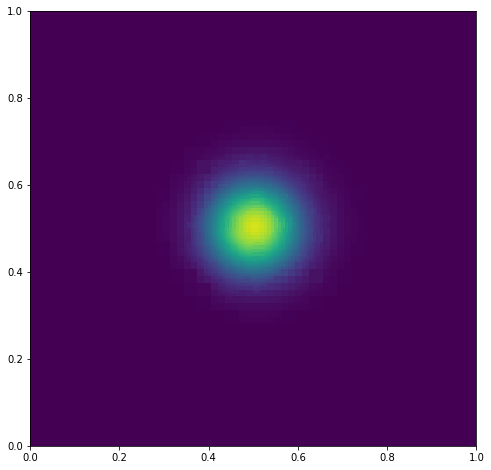

In [471]:
fig,ax=plt.subplots(figsize=(8,8))
t.plot(fig=fig,ax=ax,cmap='viridis_r',vmin=.5,vmax=1)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
fig.savefig('test6.png')

In [227]:
t.start_refine()
for c in t.empty_leaves():
    node = t.find(c)
    node.set_data(Data(node=node))
print(t.depth(),t.compression())

3 0.515625


In [48]:
t.save('test5.h5')

In [781]:
t2.close()
t2=Tree(fname='test3.h5')
t2.build()

In [783]:
2**t2.depth()

128

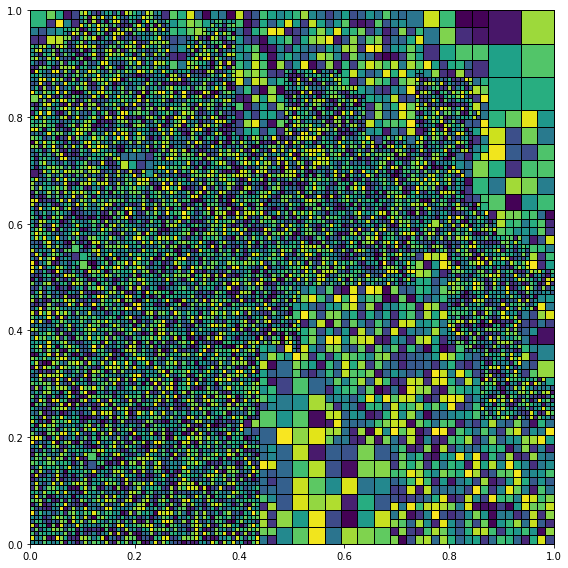

In [744]:
fig,ax=plt.subplots(figsize=(8,8))
t2.plot(fig=fig,ax=ax)
fig.tight_layout()
fig.savefig('test.png',bbox_inches='tight')

In [29]:
leaves = ['0101', '101011', '12102','10203','10304','02','0992']
lvls = np.array([len(x) for x in leaves])
maxlvl = lvls.max()
inds = np.argsort(lvls)[::-1]
leaves = list(np.array(leaves)[inds])
lvls = list(lvls[inds])

In [32]:
leaves,lvls,maxlvl

(['101011', '10304', '10203', '12102', '0992', '0101', '02'],
 [6, 5, 5, 5, 4, 4, 2],
 6)

In [19]:
np.argsort(lvls)[::-1],np.sort(lvls)[::-1]

(array([1, 4, 3, 2, 6, 0, 5]), array([6, 5, 5, 5, 4, 4, 2]))

In [42]:
t = Tree()
t.build()

AttributeError: 'Tree' object has no attribute 'fname'

In [152]:
def mod_2pi(y):
    s = y.shape
    res = y.ravel().copy()
    for i,x in enumerate(res.ravel()):
        while x > np.pi:
            x -= 2*np.pi
        while x < -np.pi:
            x += 2*np.pi
        res[i] = x
#     res = res % 2*np.pi
#     ind = res < 0
#     res[ind] += 2*np.pi
    res = res.reshape(s)
    print(res.min(),res.max())
    return res

-3.1415436079 3.13656596353


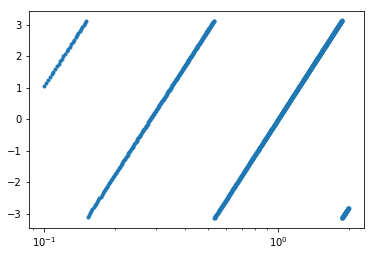

In [158]:
logspiral = lambda r,a,b: mod_2pi(np.log(r/a)/b)
plt.semilogx(np.linspace(.1,2,1000),logspiral(np.linspace(.1,2,1000),1.,.2),'.')

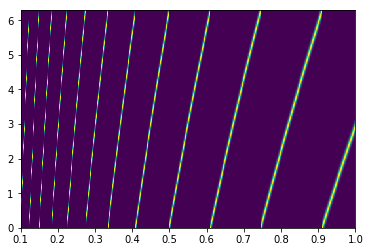

In [94]:
plt.pcolormesh(xx,yy,np.exp( -(yy-logspiral(xx,.5,.1))**2/(2*.1**2)))

-3.14144224156 3.14147395181


(-1, 1)

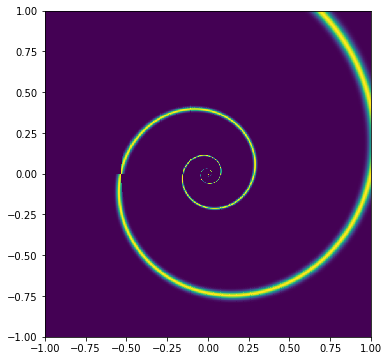

In [160]:
# def mod_2pi(y):
#     res = y.copy()
#     for i,x in enumerate(res):
#         x = x % 2*np.pi
#         if x < 0:
#             x += 2*np.pi
#         res[i] = x
#     return res
    
def maxfunc(dx):
    res = dx.copy()
    ind = abs(res)>np.pi
    res[ind] = 100
    return res
logspiral = lambda r,a,b: mod_2pi(np.log(r/a)/b)

x = np.linspace(-1,1.,512)
y = np.linspace(-1.,1,512)
xx,yy = np.meshgrid(x,y,indexing='ij')
r = np.sqrt(xx**2 + yy**2)
theta = np.arctan2(yy,xx) 
#xx,yy = np.meshgrid(r,theta,indexing='ij')
zz = np.exp( -( (theta-logspiral(r,1.,.2))**2)/(2*.1**2))
# xc = xx*np.cos(yy)
# yc = xx*np.sin(yy)
fig,ax=plt.subplots(figsize=(6,6))
ax.pcolormesh(xx,yy,zz,vmin=0,vmax=1)
ax.set_aspect('equal')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

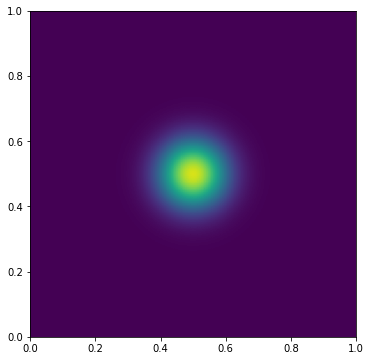

In [204]:
x = np.linspace(0,1,512)
y = np.linspace(0,1,512)
xx,yy = np.meshgrid(x,y,indexing='ij')
r = np.sqrt((xx-.5)**2 + (yy-.5)**2)*10
p = lambda x,y: (1 - (5./3-1) * 5**2 /(8*5./3*np.pi**2) * np.exp(1.-100*((x-.5)**2+(y-.5)**2)))**(1./(5./3-1))
fig,ax=plt.subplots(figsize=(6,6))
ax.pcolormesh(xx,yy,p(xx,yy),cmap='viridis_r',vmin=.5,vmax=1)
ax.set_aspect('equal')


In [201]:
p(xx,yy).min()

0.53106621737147663

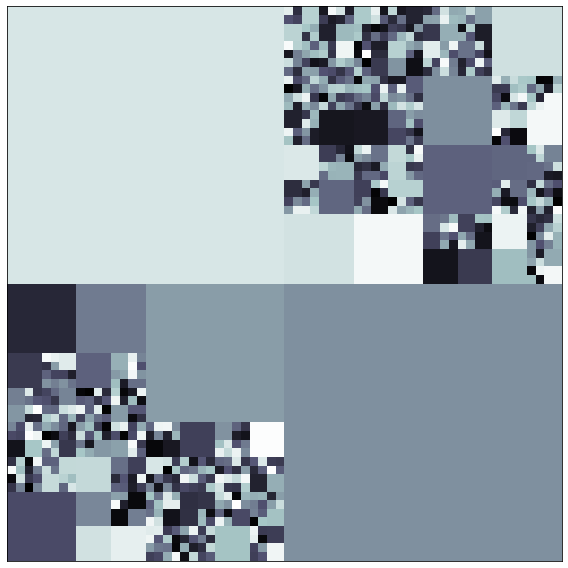

In [199]:
t = Tree(fname='test.h5')
t.build()
fig,ax=plt.subplots(figsize=(8,8))
t.root.plot(ax)
ax.tick_params(axis='both',which='both',top='off',right='off',left='off',bottom='off',labelbottom='off',labelleft='off')
ax.set_aspect('equal')
fig.tight_layout()
#fig.savefig('ex5.png',bbox_inches='tight')

In [252]:
t.close()
t = Tree(fname='test.h5')
t.build()

In [253]:
nodes = t.list_leaves()

In [254]:
res = t.find('033201')
n1,n2 = res.find_neighbors()

In [256]:
print(res)
print(n2)
print(n1)

033201
['03302', '03302', '03303', '03320', '03320', '03321', '03320', '03320', '03321']
['033022', '033023', '033032', '033200', '033201', '033210', '033202', '033203', '033212']


In [259]:
print(res)
for i in n2:
    n = t.find(i)
    print(i,n)



033201
03302 None
03302 None
03303 None
03320 03320
03320 03320
03321 03321
03320 03320
03320 03320
03321 03321


In [263]:
print(t.find('0330'))

True


0.875 0.78125
(5, 28, 25)


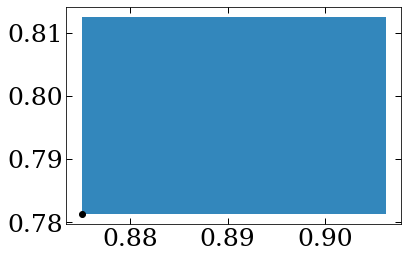

In [242]:
fig,ax=plt.subplots()
res = t.find('033201')
x,y = res.get_xy()
print(x,y)
print(res.global_index,)
res.plot(ax)
ax.plot(x,y,'ko')